In [1]:
#import libraries and functions
import numpy as np
from arqtic.program import Program, random_bitstring
from arqtic.hamiltonians import Ising_Hamiltonian
from arqtic.arqtic_for_ibm import run_ibm, get_ibm_circuit
import arqtic.QITE as qite
import qiskit as qk
from qiskit import Aer, IBMQ, execute
import matplotlib.pyplot as plt

In [2]:
#interfacing with IBM
########################################
#The following only needs to be run if this you very first time running this pynb, comment out all subsequent times
#qk.IBMQ.save_account('API_token_here')
#qk.IBMQ.load_account()
########################################

#set up simulator
simulator = Aer.get_backend('qasm_simulator')
#set optimization level for transpiler
opt_level = 3

In [3]:
#define post-processing functions
#get amouot of work from QC results
def get_work(results, shots):
    work = 0
    for result in results:
        state_vec = result[0]
        count = result[1]
        work_comp = 0
        for i in range(len(state_vec)):
            if (state_vec[i] == 0):
                work_comp += 1
            else:
                work_comp += -1
        work_comp *= count
        work += work_comp
    work = work/shots
    return work

In [31]:
#define system variables
N = 3 #number of qubits
Jz = 0.1 #ising interaction strength !!! Not used for 1-qubit
mu_x = 0.3 #transverse magnetic field strength
param_free_ham = Ising_Hamiltonian(N, Jz, [mu_x, 0, 0]) #parameter-free Hamiltonian
ising_ham0 = Ising_Hamiltonian(N, Jz, [mu_x, 0, 0]) #Hamiltonian at beginning of parameter sweep

#define simulation variables
tau = 10 #total trajectory time to evolve lambda from 0 to 1
dtau = 1.0 #time-step for trajectory
num_steps = int(tau/dtau)
T = 1 #total number of trajectories
dt =  dtau #timestep for Trotter approx: setting equal to dtau means one trotter-step per time-step in evolution
lambda_protocol = np.linspace(1.0, 0,num_steps)
dldt = (lambda_protocol[1]-lambda_protocol[0])/dtau # d(lambda)/d(tau)
print(lambda_protocol)
#define QITE variables
beta = 4.0 #inverse temperature of systems
dbeta = 0.5 #step-size in beta for QITE
domain = 3 #domain of opertators for QITE

[1.         0.88888889 0.77777778 0.66666667 0.55555556 0.44444444
 0.33333333 0.22222222 0.11111111 0.        ]


In [32]:
#create program to move to x-basis for measurement
prog_xBasis = Program(N)
prog_xBasis.get_x_basis_prog()

#first state should be random
measured_metts_state = random_bitstring(N)
#subsequent entries are derived from running QMETTS on the previously derived
#state and measuring a random observable to get the state for the subsequent run

#need to sum work over each trajectory and then average over works
work = []
#loop over trajectories
for i in range(T):
    #print(i)
    psi0 = qite.get_state_from_string(measured_metts_state)
    prog_TS = Program(N)
    prog_TS.make_ps_prog(measured_metts_state)
    prog_qite = Program(N)
    #note QITE algorithm should evolve state by beta/2 for temperature beta
    prog_qite.make_QITE_prog(ising_ham0, beta/2.0, dbeta, domain, np.asarray(psi0), 1.0)
    prog_TS.append_program(prog_qite)
    #make and run qmetts program
    prog_qmetts = Program(N)
    prog_qmetts.append_program(prog_TS)
    #make random measurement operator
    if (i%2 == 0):
        prog_qmetts.append_program(prog_xBasis)
    #get gate counts for QMETTS circuit
    QMETTS_ibm_circuit = get_ibm_circuit(simulator, prog_qmetts, transpile=False)
    QMETTS_ibm_circ = get_ibm_circuit(simulator, prog_qmetts, transpile=True, opt_level=3)
    print("QMETTS circuit pre-compiliation")
    print(QMETTS_ibm_circuit.count_ops())
    print("QMETTS circuit post-compiliation")
    print(QMETTS_ibm_circ.count_ops())
    #print("QMETTS circuit")
    #prog_qmetts.print_list()
    results = run_ibm(simulator, prog_qmetts,1)
    #update measured metts state for next trajectory
    measured_metts_state = results[0][0]
    #make and run JE program
    prog_JE = Program(N)
    prog_JE.append_program(prog_TS)
    #loop over time-steps in trajectory i
    work_i = 0
    gate_dict_array_pre = []
    gate_dict_array_post1 = []
    gate_dict_array_post3 = []
    for step in range(num_steps):
        print(step)
        #make Hamilton Evolution program for given time-step of given trajectory
        prog_hamEvol = Program(N)
        prog_hamEvol.make_hamEvol_prog(step, dtau, dt, lambda_protocol, param_free_ham)
        #complete JE program: combing IPS preparation, QITE, and Hamiltonian evolution
        prog_JE.append_program(prog_hamEvol)
        prog_JE.append_program(prog_xBasis)
        #get prog_JE as an IBM circuit
        JE_ibm_circuit = get_ibm_circuit(simulator, prog_JE, transpile=False)
        JE_ibm_circ_opt1 = get_ibm_circuit(simulator, prog_JE, transpile=True, opt_level=1)
        JE_ibm_circ_opt3 = get_ibm_circuit(simulator, prog_JE, transpile=True, opt_level=3)
        gate_dict_array_pre.append(JE_ibm_circuit.count_ops())
        gate_dict_array_post1.append(JE_ibm_circ_opt1.count_ops())
        gate_dict_array_post3.append(JE_ibm_circ_opt3.count_ops())


QMETTS circuit pre-compiliation
OrderedDict([('rx', 46), ('rz', 27), ('h', 15), ('cx', 14), ('x', 1)])
QMETTS circuit post-compiliation
OrderedDict([('cx', 10), ('u3', 7), ('u2', 6), ('u1', 6)])
0
1
2
3
4
5
6
7
8
9


In [33]:
print(len(prog_JE.gates))

805


In [34]:
print(len(JE_ibm_circuit))
print(len(JE_ibm_circ_opt1))
print(len(JE_ibm_circ_opt3))

805
443
431


In [35]:
print(gate_dict_array_pre)
print(gate_dict_array_post1)
print(gate_dict_array_post3)

[OrderedDict([('rx', 46), ('rz', 27), ('h', 15), ('cx', 14), ('x', 1)]), OrderedDict([('rx', 46), ('rz', 32), ('h', 24), ('cx', 18), ('x', 1)]), OrderedDict([('rx', 46), ('rz', 42), ('h', 39), ('cx', 26), ('x', 1)]), OrderedDict([('h', 60), ('rz', 57), ('rx', 46), ('cx', 38), ('x', 1)]), OrderedDict([('h', 87), ('rz', 77), ('cx', 54), ('rx', 46), ('x', 1)]), OrderedDict([('h', 120), ('rz', 102), ('cx', 74), ('rx', 46), ('x', 1)]), OrderedDict([('h', 159), ('rz', 132), ('cx', 98), ('rx', 46), ('x', 1)]), OrderedDict([('h', 204), ('rz', 167), ('cx', 126), ('rx', 46), ('x', 1)]), OrderedDict([('h', 255), ('rz', 207), ('cx', 158), ('rx', 46), ('x', 1)]), OrderedDict([('h', 312), ('rz', 252), ('cx', 194), ('rx', 46), ('x', 1)])]
[OrderedDict([('cx', 14), ('u2', 10), ('u1', 10), ('u3', 4)]), OrderedDict([('cx', 18), ('u1', 12), ('u2', 11), ('u3', 6)]), OrderedDict([('cx', 26), ('u1', 16), ('u2', 14), ('u3', 9)]), OrderedDict([('cx', 38), ('u1', 22), ('u2', 17), ('u3', 15)]), OrderedDict([('c

In [13]:
#save data to file
fname = 'mu_x_{}_beta_{}_hist.csv'.format(mu_x, beta)
f = open(fname, 'w')
f.write("N: "+ str(N) + '\n')
f.write("mu_x: "+ str(mu_x) + '\n')
f.write("beta: "+ str(beta) + '\n')
f.write("dbeta: "+ str(dbeta) + '\n')
f.write("T: "+ str(T) + '\n')
f.write("tau: "+ str(tau) + '\n')
f.write("dtau: "+ str(dtau) + '\n')

np.savetxt(f, work, delimiter=',')

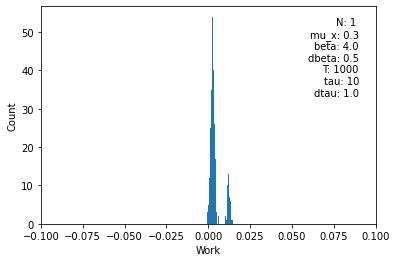

In [55]:
#plot data and save figure
nbins = 100
plt.xlabel('Work')
plt.ylabel('Count')
data_str = f"N: {N} "+"\n"+f"mu_x: {mu_x}"+"\n"+f"beta: {beta}"+"\n"+f"dbeta: {dbeta}"+"\n"+f"T: {T}"+"\n"+f"tau: {tau}"+"\n"+f"dtau: {dtau}" 
ax = plt.gca()
ax.text(0.95, 0.95, data_str,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)
plt.hist(work, bins = nbins)

#May or may not want to limit x-axis
plt.xlim(-0.1,0.1)
fname = 'mu_x_{}_beta_{}_hist.png'.format(mu_x, beta)
plt.savefig(fname)
plt.show()